# Representational Learning
Whereas traditional feature engineering required hand-made features to be created for the downstream prediction task; representational learning attempts to achieve efficient, task-independent, automatic, feature learning for machine learning with graphs. The idea is to map an aspect of the graph into a $d$-dimensional vector (embedding space), capturing the underlying structure.

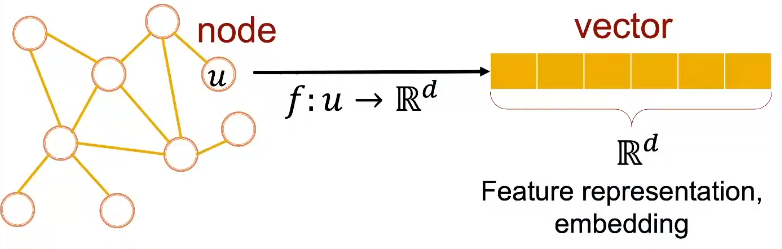

This embedding space is suppose to reflect the original aspects themselves, thereby similarities within the embeddings indicate similarity in the original structures.

## Node Embedding
For node-level tasks, with the goal of encoding nodes into an embedding space such that their similarity, evaluated by dot product, approximate similarity in the graph; the **Encoder Decoder Framework** is used.

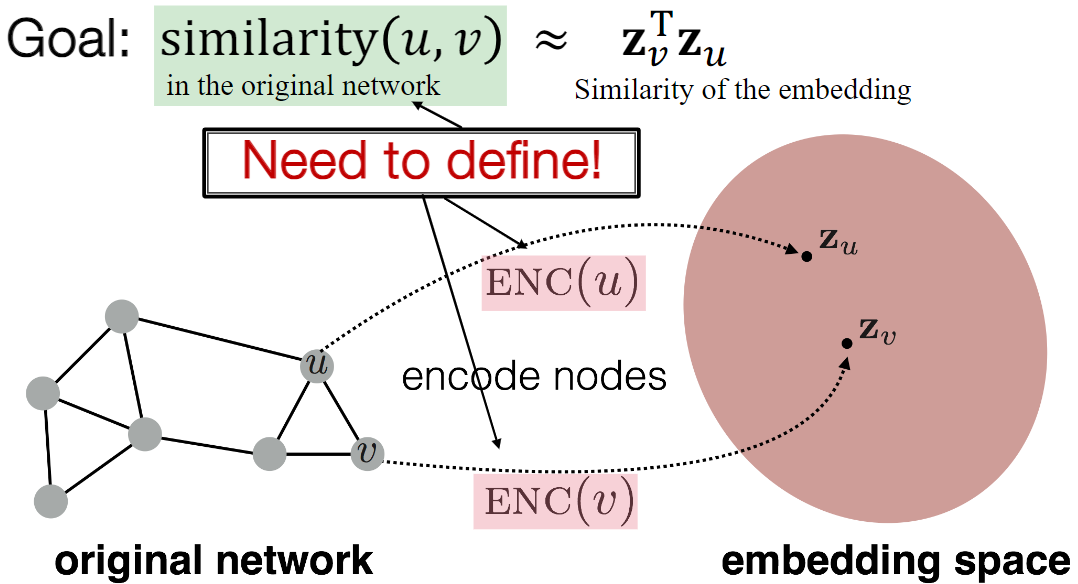
1. Encoder, $\text{ENC}:(u)\rightarrow \mathbb{R}^d=z_u$, maps from nodes to embeddings
2. Node similarity function, $\text{similarity}:(u,v)\rightarrow\mathbb{R}$, measures the similarity between nodes in the original network.
3. Decoder, $\text{DEC}:(z_u,z_v)\rightarrow\mathbb{R}$, maps embeddings to teh similarity score (most commonly $\text{DEC}(z_u,z_v)=z_u^Tz_v$).
4. Optimize the parameters of the encoder such that $\text{similarity}(u,v)\approx\text{DEC}(z_u,z_v)$

### Shallow Encoding
The simplest encoding approach is an "embedding-lookup", $\text{ENC}(u)=z_u = Z\cdot \mathcal{V}_u,\;Z\in\mathbb{R}^d\times\mathbb{R}^{|V|},\;\mathcal{V}_u\in\text{indicator}^{|V|}$, where a large matrix is learned where column $i$ corresponds to the $i^{th}$ node embedding ($\mathcal{V}_i$ is then simply a vector with all zeros except in the $i^{th}$ element where is it 1).

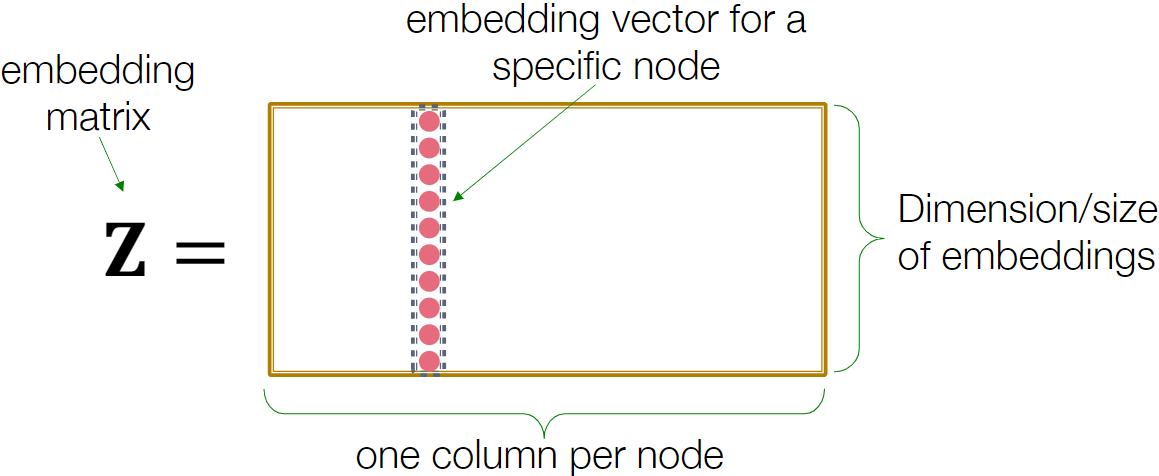

Note that this approach is not very scalable as $Z$ increases with the number of nodes in the network.

#### DeepWalk
This choice of encoder relies on the idea of **random walks** (from an initial node $u$, using some randomising algorithm move to neighbouring nodes, and after $l$ iterations record the path taken) being an (un/self-)supervised way of learning the node embeddings (task independent as not labels/features are utilized) which preserves network structures within the embedding (local and higher-order neighbourhood information), and does not require all node pairs to be considered (only neeed to consider pairs that co-occur on random walks).

By first defining the similarity function as "the probability that nodes $u$ and $v$ co-occur on a random walk over the graph", and the decoder as $z_u^Tz_v$; an embedding can be created by estimating the probability of visiting node $v$ on a random walk starting from node $u$ using some random algorithm $R$, $\mathbb{P}(v|u)$, and optimizing the embedding to encode these random statistics towards $z_u^Tz_v$.

Given $G=(V,E)$, the mapping function $f:u\rightarrow\mathbb{R}^d=z_u$ can be learned through optimizing (log-likelihood objective) $\max_f\sum_{u\in V}\log\mathbb{P}(n_R(u)|z_u)$, where $N_R(u)$ is the neighbourhood of node $u$ by strategy $R$:
1. run short fixed-length randowm walks starting at each node $u$ in teh graph using some strategy $R$
2. for each node $u$ collect the $N_R(u)$ multiset (keep repeated elements if visited multiple times)
3. optimise embedding according to $\max_f\sum_{u\in V}\log\mathbb{P}(n_R(u)|z_u)$ or equivalently minimise $\sum_{u\in V}\sum_{v\in N_R(u)}-\log\mathbb{P}(v|z_u)$
    - $\mathbb{P}(v|z_u)$ can be parameterized using the softmax equation (function turning vector of $K$ real values into $K$ probabilities that sum to 1) $\sigma(z)_i=\frac{\exp{z_i}}{\sum_{j=1}^{K}\exp{z_j}}$, $\mathbb{P}(v|z_u)=\frac{\exp{z_u^Tz_v}}{\sum_{n\in V}\exp{z_u^Tz_n}}$

Note that his is expensive as the optimisation includes a nested sum, resulting in a $O(|V|^2)$ complexity. This can be resolved using **negative sampling**, where istead of normalizing with respect ot all nodes, it is normalized against $k$ (in practice $k\in [5,20]$) random "negative sample" (each with probability proportional to its degree):$$\log(\frac{\exp{z_u^Tz_v}}{\sum_{n\in V}\exp{z_u^Tz_n}})\approx \log(S(z_u^Ts_v))-\sum_{i=1}^{k}\log(S(z_u^Tz_i))$$
- higher $k$ gives more robust estimates, and corresponds to a higher bias on negative events.

After the objective function has been obtained, stochastic gradient descent can be used to optimize it.

##### node2vec
This alteration to deep walk utilises a different $R$ definition based on the observation that a flexible notation of network neighbourhood $N_R(u)$ leads to rich node embeddings.

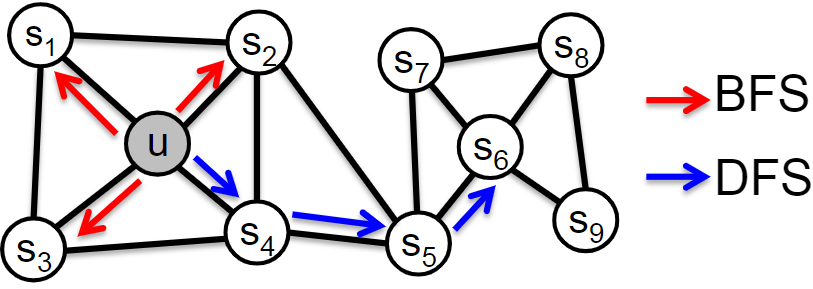

Thereby, a biased random walk that can trade off between local (Bridth First Search) and global (Depth First Search) views of the network can be achieved via the addition of 2 paramerters to $R$; return parameter $p$ (return back to the previous node), and in-out parameter $q$ (the "ratio" of BFS v DFS affinity).

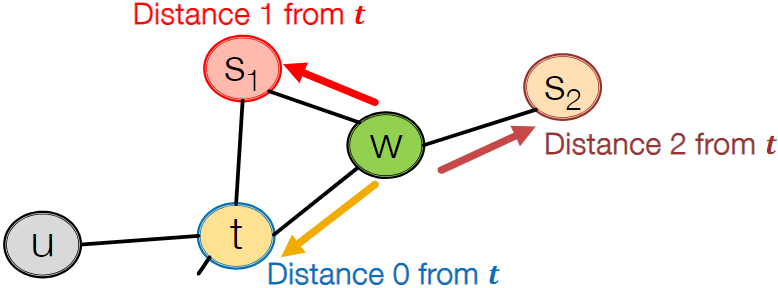

If a random walk just traversed edge $(t,w)$ and is now at $w$, edge transission probabilities (un-normalized) can be defined by the new parameters:
- transition **back** to $t$ is set to $1/p$ (low $p$ for BFS-like walk)
- transition to $s_1$ which is at the **same distance** from $t$ is set to $1$
- transition **away** from $t$ to $s_2$ is set to $1/q$ (low $q$ for DFS-like walk)

## Graph Embedding
Similar to node embeddding, network embedding are vector representations of graphs that capture local and global traits; more suitable for standard machine learning techniques (work on vectors rather than graphs). 

Feature-based embeddings are traditionaly used which attempt extract substructures from the graph into numerical form; these however produce sparse solutions as as only few subtructures are common across a graph. Data-driven methods learn optimise some objective function and as a result learn the graph embeddings; and as a result are harder to achieve but are not sparse. 

### Random Walk
Random walks are the sequences of nodes, where each new node is selected independently from the set of neighbors of the last node in the sequence. Anonymous random walk remove the global names from each node in the sequence. 

Given a graph $G=(V,E,\Omega)$ where $V=\{v_1,v_2,...,v_n\}$ is a set of vertices, $E\subseteq V\times V$ is a set of edges, and $\Omega \subset\mathbb{R}$ is a set of edge weights; let $s=(u_1,u_2,...,u_k)$ be an ordered list of elements $u_i\in V$, and function $pos:(s,u_i)\rightarrow (p_1,...,p_l)$ return a list of all positions $p_j\in\mathbb{N}$ of $u_i$ occurence in a list $s$. If $s$ is a random walk, then its corresponding anonymous random walk is the sequence of integers $a=(f(v_1),f(v_2),...,f(v_n))$, where $f(v_i)=\min_{p_j\in pos(s,v_i)} pos(s,v_i)$ (for a given walk length, there is a set number fo possible anonymous random walks)

### Anonymous Walk Embedding
It has been shown by https://dspace.mit.edu/handle/1721.1/114241 that given the distribution of random walks of length $l$ from a node $u$, $\mathcal{D_l}$ (from it, one can simulate access to the distributions $\mathcal{D_1},...,\mathcal{D_{l-1}}$), reconstruction of $B(v,r)$ is possible; a ball of centre $v$ and radius $r$ (subgraph of $G$ induced by all vertices whose distance from $v$ is at most $r$)

Using this, https://arxiv.org/abs/1805.11921 devised a feature-based and data-driven models for anonymous walk graph embeddings:
#### Feature-Based model
Let $\mathcal{A_l}=(a_1,a_2,...,a_\eta)$ be the set of all possible anonymous walks of length $l$; the vector $f_G=(\mathbb{P}(a_1), \mathbb{P}(a_2), ..., \mathbb{P}(a_\eta))$ will then be the anonymous walk embedding of graph $G$.

Where $f_G[i]$ is the probability of an anonymous random walk $a_i$ in $G$, $\mathbb{P}(a_i)=\frac{1}{N}\sum_{u\in G}\mathbb{P}(a_i^u)=\frac{1}{N}\sum_{u\in G}\sum_{w\rightarrow a_i\in W_l^u}\mathbb{P}(w)$; being the sum of all **random walk probabilities** which convert to the same anonymous random walk across all nodes in the graph.

Random walk probability, $\mathbb{P}(w)=\prod_{e\in w}\frac{w_e}{\sum_{v\in N_{\text{out}}}w_{(u,v)}}$; is the probabilty of a given random walk $w$, as the product of the probability of moving across any given edge $w_e$ in $w$.

To achieve this, a running time of $O(nl(d_in^{max}d_out^{max})^{l/2})$ is needed ($d^{max}_{in|out}$ is the maximum in/out degree in graph $G$). However, sampling can be used to generate an empirical distribution $\mathscr{D}^m$ of the original distribution $\mathscr{D}_l$ such that $\mathbb{P}\{||\mathscr{D}^m- \mathscr{D}_l||_1>\epsilon\}\leq \sigma, \epsilon>0, \sigma\in [0,1]$ if the numer of samples are $$m=\lceil \frac{2}{\epsilon^2}(\log(2^\eta-2)-\log(\sigma))\rceil$$

#### Data-Driven model
iterate over each vertex $u$ in a graph $G$, sampling $T$ random walks $(w_1^u,w_2^u,...,w_T^u)$ that starts at node $u$ and map to a sequence of **co-occured** anonymous walks $s^u=(a_1^u,a_2^u,...,a_T^u)$. The collection of all $s^u$ for all vertices $u\in G$ is a corpus of co-occured anonymous walks in a graph.

Formally then, a sequence of co-occured anonymous walks $s=(a_1^u,a_2^u,...,a_T^u)$ corresponds to vectors $\text{w}_1,\text{w}_2,...,\text{w}_T$ of anonymous walks matrix $\text{W}\in\mathbb{R}^\eta\times\mathbb{R}^{d_a}$, and a graph $G$ corresponding to vector $\text{d}\in\mathbb{R}^{d_g}$. The model then tries to predict a target anonymous walk given co-occuring context anonymous walks and a graph: 

$$\max\frac{1}{T}\sum_{t=\Delta}^{T-\Delta}\log\mathbb{P}(\text{w}_t|\text{w}_{t-\Delta},...,\text{w}_{t+\Delta},\text{d})$$

for window size $\Delta$ ($T=k\Delta, k>3$), where the probability is defined objectively via softmax function (requires enough samples such that any given walk $\text{w}_i, i\in \{1,...,\eta\}$ has at least $\Delta$ walks before and after it in the sample sequence) 

$$\mathbb{P}(\text{w}_t|\text{w}_{t-\Delta},...,\text{w}_{t+\Delta},\text{d})=\frac{e^{y(\text{w}_t)}}{\sum_{i=1}^\eta e^{y(\text{w}_i)}}, y(\text{w}_t)=b+U\text{concat}(\frac{1}{2\Delta}\sum_{j=-\Delta}^\Delta\text{w}_{t+j}, \text{d})$$ 
$ b\in\mathbb{R}, U\in\mathbb{R}^{d_a+d_g}$ (softmax parameters)

To avoid computation of the sum in the softmax equation (becomes impractical for large sets), sampling techniques can be used; with one of the simplest being **negative sampling**: $$\log\frac{e^{y(\text{w}_t)}}{\sum_{i=1}^\eta e^{y(\text{w}_i)}}, y(\text{w}_t)\approx \log S(y(\text{w}_t))- \sum_{i=1}^k\log S(y(\text{w}_i))$$ where instead of softmax, a sigmoid function is used (turns real values into range of $(0,1)$ ) $S(x)=\frac{1}{1+e^{-x}}$. Parameter $k\in\mathbb{N}$ and in practice $k\in[5,20]$ (higher $k$ gives a more robust estimate, corresponding to a higher bias on negative events)